<a href="https://colab.research.google.com/github/Aparajithashri/Baby-doll-Classifier/blob/master/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [58]:
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from random import shuffle
im='/content/drive/My Drive/Colab Notebooks/classifier/'
i='/content/drive/My Drive/Colab Notebooks/classifier_test/'
TRAIN_DIR = 'train'
TEST_DIR = 'test'
IMG_SIZE = 28
LR = 0.01
dropout=0.75
n_classes=2
n_input=291
train_iter=2000000
display=100
batch_size=10
x=tf.placeholder(tf.float32,[28,28,1])
y=tf.placeholder(tf.float32)
keep_prob=tf.placeholder(tf.float32)
MODEL_NAME = 'baby-vs-doll-convnet'
def label(im):
  word=im[51:55]
 
  if word == 'baby':
    return [0]
  elif word == 'doll':
    return [1]
a=[]

def create_train_data():
    training_data = []
    for f in os.listdir(im):
	      a.append(os.path.join(im,f))
    for img in a:
        label_im = label(img)
        imgs = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        imgs = cv2.resize(imgs,(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(imgs),np.array(label_im)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data
b=[]
def create_test_data():
    testing_data = []
    for f in os.listdir(i):
	      b.append(os.path.join(i,f))
    for img in b:
        img_num = img.split('.')[0]
        img_data = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img_data),img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data
train_data = create_train_data()
test_data = create_test_data()
train = train_data
test = test_data
X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y_train = [i[1] for i in train]

X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

Y_test = [i[1] for i in test]

#tf.reset_default_graph()
def conv2d(x,w,b,stride=1):
  x=tf.nn.conv2d(x,w,strides=[1,stride,stride,1],padding="SAME")
  x=tf.nn.bias_add(x,b)
  return tf.nn.relu(x)
def maxpool(x,k=2):
  return tf.nn.max_pool2d(x,ksize=[1,k,k,1],strides=[1,k,k,1],padding="SAME")
def convnet(x,weights,biases,dropout):
  x = tf.reshape(x, shape=[-1, 28, 28, 1])
  conv1=conv2d(x,weights['wc1'],biases['bc1'])
  conv1=maxpool(x,k=2)
  

  conv2=conv2d(conv1,weights['wc2'],biases['bc2'])
  conv2=maxpool(conv2,k=2)

  fc1=tf.reshape(conv2,[-1,weights['wd1'].get_shape().as_list()[0]])
  fc1=tf.add(tf.matmul(fc1,weights['wd1']),biases['bd1'])
  fc1=tf.nn.relu(fc1)

  fc1=tf.nn.dropout(fc1,dropout)

  out=tf.add(tf.matmul(fc1,weights['out']),biases['out'])
  
  return out

weights={'wc1':tf.Variable(tf.random_normal([5,5,1,32])),
         'wc2':tf.Variable(tf.random_normal([5,5,1,64])),
         'wd1':tf.Variable(tf.random_normal([7*7*64,1024])),
         'out':tf.Variable(tf.random_normal([1024,n_classes]))}
biases={
    'bc1':tf.Variable(tf.random_normal([32])),
    'bc2':tf.Variable(tf.random_normal([64])),
    'bd1':tf.Variable(tf.random_normal([1024])),
    'out':tf.Variable(tf.random_normal([n_classes]))
}
#tf.Graph().as_default()

pred=convnet(x,weights,biases,keep_prob)
sig=tf.nn.sigmoid_cross_entropy_with_logits(labels=pred,logits=y)
cost=tf.reduce_mean(sig)
optimizer=tf.train.AdamOptimizer(learning_rate=LR).minimize(cost)
crt_pred=tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(crt_pred,tf.float32))

init=tf.initialize_all_variables()

with tf.Session() as sess:
  
  sess.run(init)
  step=1
  sess.run(tf.global_variables_initializer())
  
  while step * batch_size<train_iter:
    for i in X_train:
      l=np.asarray(i[1]).astype('float32').reshape((-1,1))
      sess.run(optimizer,feed_dict={x:i,y:l,keep_prob:dropout})
      
      if step%display==0:
        loss,acc=sess.run([cost,accuracy],feed_dict={x:i,y:l,keep_prob:1.})
        print("Iter"+str(step)+",Min loss="+"{:.6f}".format(loss)+", Training acc="+"{:.5f}".format(acc))
      step+=1
      
  
  print("Optimized")
  for i in X_test:
    i=i.reshape([28,28,1])
    l=np.asarray(i[1]).astype('float32').reshape((-1,1))
    print("Testing Accuracy:",sess.run(accuracy,feed_dict={x:i,y:l,keep_prob:1.}))

Iter100,Min loss=-546238201856.000000, Training acc=1.00000
Iter200,Min loss=-5084469526528.000000, Training acc=1.00000
Iter300,Min loss=-60820725694464.000000, Training acc=1.00000
Iter400,Min loss=-15488601030656.000000, Training acc=1.00000
Iter500,Min loss=-229692435070976.000000, Training acc=1.00000
Iter600,Min loss=-628306537873408.000000, Training acc=1.00000
Iter700,Min loss=-838038850633728.000000, Training acc=1.00000
Iter800,Min loss=-1359561428566016.000000, Training acc=1.00000
Iter900,Min loss=-2486873305907200.000000, Training acc=1.00000
Iter1000,Min loss=-2675749056151552.000000, Training acc=1.00000
Iter1100,Min loss=-2477775491432448.000000, Training acc=1.00000
Iter1200,Min loss=-2554726541426688.000000, Training acc=1.00000
Iter1300,Min loss=-7543700422918144.000000, Training acc=1.00000
Iter1400,Min loss=-2222047098830848.000000, Training acc=1.00000
Iter1500,Min loss=-2544272054157312.000000, Training acc=1.00000
Iter1600,Min loss=-12313166578974720.000000, Tra

In [0]:
tf.nn.

baby: 0.9999990463256836, doll: 9.893924470816273e-07


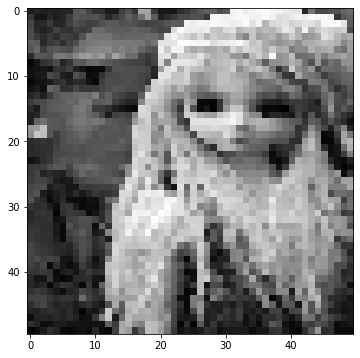

In [64]:
import cv2 
import os 
import numpy as np 
from random import shuffle 
import tensorflow as tf
import tflearn
import matplotlib.pyplot as plt
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
im='/content/drive/My Drive/Colab Notebooks/classifier/'
i='/content/drive/My Drive/Colab Notebooks/classifier_test/'
TRAIN_DIR = 'train'
TEST_DIR = 'test'
IMG_SIZE = 50
LR = 0.001
MODEL_NAME = 'baby-vs-doll-convnet'
def label(im):
  word=im[51:55]
 
  if word == 'baby':
    return [1,0]
  elif word == 'doll':
    return [0,1]
a=[]

def create_train_data():
    training_data = []
    for f in os.listdir(im):
	      a.append(os.path.join(im,f))
    for img in a:
        label_im = label(img)
        imgs = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        imgs = cv2.resize(imgs,(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(imgs),np.array(label_im)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data
b=[]
def create_test_data():
    testing_data = []
    for f in os.listdir(i):
	      b.append(os.path.join(i,f))
    for img in b:
        img_num = img.split('.')[0]
        img_data = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img_data), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data
train_data = create_train_data()
test_data = create_test_data()
train = train_data
test = test_data
X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = [i[1] for i in train]

X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = [i[1] for i in test]
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')
model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)
"""model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
         validation_set=({'input': X_test}, {'targets': y_test}), 
         snapshot_step=500, show_metric=True, run_id=MODEL_NAME)
"""
d = test_data[0]
img_data, img_num = d

data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
prediction = model.predict([data])[0]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap="gray")
print(f"baby: {prediction[0]}, doll: {prediction[1]}")